In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from einops.layers.tensorflow import Rearrange
import math

import numpy as np
import matplotlib.pyplot as plt


In [4]:
def gelu(x):
    """Smoothened Gaussian Error Linear Unit activation function.
    args:
        x: input tensor
    returns:
        output tensor after applying gelu"""
    fn = 0.5 * x * (1.0 + tf.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * tf.pow(x, 3))))
    return fn

class PatchExtract(tf.keras.layers.Layer):
    """Extracts patches from the input image"""
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
        self.rearrange = Rearrange('b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)

    def call(self, img):
        return self.rearrange(img)


class Residual(tf.keras.layers.Layer):
    """Residual skip connection in Encoder"""
    def __init__(self, func):
        super().__init__()
        self.func = func

    def call(self, x):
        return self.func(x) + x

class PreNorm(tf.keras.layers.Layer):
    """Layer normalization before attention and MLP blocks"""
    def __init__(self, dim, func):
        super().__init__()
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.func = func

    def call(self, x):
        return self.func(self.norm(x))

class FeedForward(tf.keras.layers.Layer):
    """Feed forward MLP for transformer block"""
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.ff = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim, activation=tf.keras.activations.get(gelu)),
            tf.keras.layers.Dense(dim)
        ])

    def call(self, x):
        return self.ff(x)

class Attention(tf.keras.layers.Layer):
    """Multi-head self attention layer"""
    def __init__(self, dim, heads):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = tf.keras.layers.Dense(dim * 3, use_bias=False)
        self.to_out = tf.keras.layers.Dense(dim)

        self.rearrange_qkv = Rearrange('b n (qkv h d) -> qkv b h n d', qkv=3, h=self.heads)
        self.rearrange_out = Rearrange('b h n d -> b n (h d)')

    def call(self, x):
        qkv = self.to_qkv(x)
        qkv = self.rearrange_qkv(qkv)

        q = qkv[0]
        k = qkv[1]
        v = qkv[2]

        mul = tf.einsum('bhid,bhjd->bhij',q, k) * self.scale
        attn = tf.nn.softmax(mul, axis=-1)

        out = tf.einsum('bhij,bhjd->bhid', attn, v)
        out = self.rearrange_out(out)
        out = self.to_out(out)

        return out

class Transformer(tf.keras.Model):
    """Transformer block consisting of attention and MLP layers"""

    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.extend([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ])
        self.net = tf.keras.Sequential(layers)

    def call(self, x):
        return self.net(x)


class ViT(tf.keras.Model):
    """Vision Transformer model"""

    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size
        self.dim = dim

        self.patch_extractor = PatchExtract(patch_size)
        self.patch_to_embedding = tf.keras.layers.Dense(dim)

        self.cls_token = self.add_weight(
            name='cls_token',
            shape=(1, 1, dim),
            initializer=tf.keras.initializers.RandomNormal(),
            dtype=tf.float32
            )

        self.pos_embedding = self.add_weight(
            name='pos_embedding',
            shape=(num_patches + 1, dim),
            initializer=tf.keras.initializers.RandomNormal(),
            dtype=tf.float32
            )

        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = tf.keras.layers.Identity()

        self.mlp_head = tf.keras.Sequential([
            tf.keras.layers.Dense(mlp_dim, activation=tf.keras.activations.get(gelu)),
            tf.keras.layers.Dense(num_classes)
        ])

    def call(self, img):
        b = tf.shape(img)[0]
        x = self.patch_extractor(img)
        x = self.patch_to_embedding(x)


        cls_tokens = tf.broadcast_to(self.cls_token, [b, 1, self.dim])
        x = tf.concat([cls_tokens, x], axis=1)
        x += self.pos_embedding

        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)


In [5]:
# Load CIFAR-10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = y_train.flatten()
y_test = y_test.flatten()

BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [6]:
lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=10,
    min_lr=1e-5,
    verbose=1
)

es = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

In [7]:
# ViT Configuration
vit_config = dict(
    image_size=32,
    patch_size=4,
    num_classes=10,
    dim=64,
    depth=6,
    heads=8,
    mlp_dim=128,
)

model = ViT(**vit_config)

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[es, lr]
)

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.2508 - loss: 2.0365 - val_accuracy: 0.4495 - val_loss: 1.5138 - learning_rate: 0.0010
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.4917 - loss: 1.3962 - val_accuracy: 0.5296 - val_loss: 1.2998 - learning_rate: 0.0010
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5448 - loss: 1.2596 - val_accuracy: 0.5493 - val_loss: 1.2406 - learning_rate: 0.0010
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5733 - loss: 1.1887 - val_accuracy: 0.5506 - val_loss: 1.2587 - learning_rate: 0.0010
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5945 - loss: 1.1170 - val_accuracy: 0.5758 - val_loss: 1.1838 - learning_rate: 0.0010
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6157 - loss: 1.0723 - val_accuracy: 0.5908 - val_loss: 1.1454 - learning_rate: 0.0010
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6

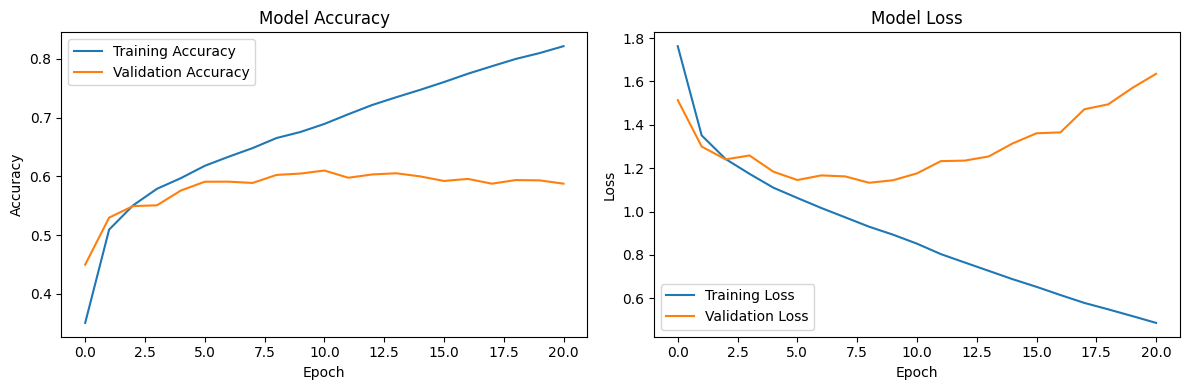

In [9]:
# Plot training & validation accuracy, loss values
history = model.history.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy values
ax1.plot(history['accuracy'], label='Training Accuracy')
ax1.plot(history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot training & validation loss values
ax2.plot(history['loss'], label='Training Loss')
ax2.plot(history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.tight_layout()
plt.show()

In [10]:
val_acc = model.history.history['val_accuracy']
train_acc = model.history.history['accuracy']

best_epoch = int(tf.argmax(val_acc))
best_val_acc = val_acc[best_epoch]
best_train_acc = train_acc[best_epoch]

print(f"Best Epoch: {best_epoch + 1}")
print(f"Best Val Accuracy: {best_val_acc * 100:.2f}%")
print(f"Train Accuracy at that epoch: {best_train_acc * 100:.2f}%")

Best Epoch: 11
Best Val Accuracy: 60.99%
Train Accuracy at that epoch: 68.93%
